In [1]:
import os
import pandas as pd
from scipy.stats import rankdata
import seaborn as sns
import numpy as np
import logging
from matplotlib import pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

import statsmodels
from scipy.spatial.distance import pdist, squareform

from nltools.data import Brain_Data, Adjacency
from sklearn.metrics import pairwise_distances

from nltools.stats import fdr, threshold
from scipy.stats import rankdata, ttest_rel, ttest_1samp

In [2]:
import nilearn
from nilearn import image
import nibabel as nib
from nltools.data import Brain_Data
from nltools.external import glover_hrf
from nltools.mask import expand_mask, roi_to_brain
from nilearn.input_data import NiftiLabelsMasker
from nilearn.maskers import NiftiMasker
from nilearn.plotting import plot_glass_brain, plot_stat_map, view_img, view_img_on_surf

C:\Users\MYCS\anaconda3\lib\site-packages\nilearn\input_data\__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [10]:
cmap = plt.cm.get_cmap('RdYlBu_r')
cmap.set_bad('#C0C0C0')

# Define some helper functions
def sort_square_mtx(mtx, vct):
    """
    Sorts rows/columns of a matrix according to a separate vector.
    """
    
    inds = vct.argsort()
    mtx_sorted = mtx.copy()
    mtx_sorted = mtx_sorted[inds, :]
    mtx_sorted = mtx_sorted[:, inds]

def scale_mtx(mtx):
    """
    Scales a matrix to have values between 0 and 1.
    """
    return (mtx-np.min(mtx))/(np.max(mtx)-np.min(mtx))

C:\Users\MYCS\AppData\Local\Temp\ipykernel_45808\2012579416.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('RdYlBu_r')


In [11]:
df = pd.read_excel("path-to-dataset")

## Behavoral data processing and matrices construction 

In [20]:
Behav_raw = df["Behav"].toarray()

In [23]:
Behav_rank = rankdata(Behav_raw) 

In [26]:
# First, choose number of subjects and simulate behavior chosen from random distribution
# n_subs = 100
# behav_raw = np.random.randn(n_subs)
# behav = rankdata(behav_raw)-1

cmap = plt.cm.get_cmap('RdYlBu_r')
cmap.set_bad('#C0C0C0')

# Define some helper functions
def sort_square_mtx(mtx, vct):
    """
    Sorts rows/columns of a matrix according to a separate vector.
    """
    
    inds = vct.argsort()
    mtx_sorted = mtx.copy()
    mtx_sorted = mtx_sorted[inds, :]
    mtx_sorted = mtx_sorted[:, inds]
    
    return mtx_sorted

def scale_mtx(mtx):
    """
    Scales a matrix to have values between 0 and 1.
    """
    return (mtx-np.min(mtx))/(np.max(mtx)-np.min(mtx))

C:\Users\MYCS\AppData\Local\Temp\ipykernel_45808\2643323627.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('RdYlBu_r')


Text(0.5, 1.0, 'Behavioral similarity matrix after sorting')

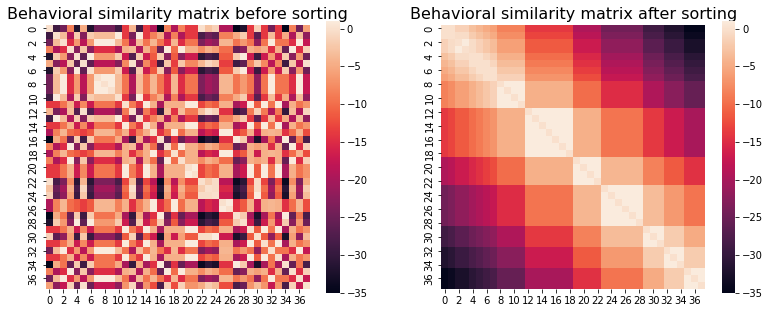

In [27]:
behav_rank = Behav_rank 
behav_sim_nn = Adjacency(pairwise_distances(np.reshape(behav_rank, (-1, 1)), metric='euclidean'), matrix_type='distance')
behav_sim_nn = behav_sim_nn.distance_to_similarity()

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(13,5))
behav_sim_nn.plot(axes=ax1)
ax1.set_title("Behavioral similarity matrix before sorting", fontsize=16)

sns.heatmap(sort_square_mtx(behav_sim_nn.squareform(), behav_rank), ax = ax2, square=True)
ax2.set_title("Behavioral similarity matrix after sorting", fontsize=16)

Text(0.5, 1.0, 'Behavioral similarity matrix after sorting')

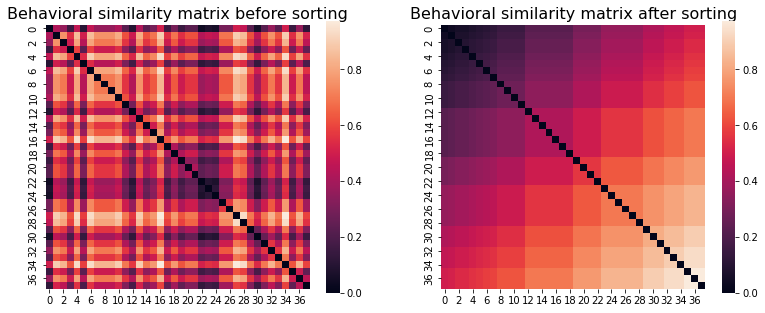

In [28]:
nsub = num_of_sub
behav_rank = Behav_rank 
behav_sim_annak = np.zeros((nsub, nsub))

for i in range(nsub):
    for j in range(nsub):
        if i < j:
            sim_ij = np.mean([behav_rank[i], behav_rank[j]])/nsub
            behav_sim_annak[i,j] = sim_ij
            behav_sim_annak[j,i] = sim_ij
        elif i==j:
            behav_sim_annak[i,j] = 1

behav_sim_annak = Adjacency(behav_sim_annak, matrix_type='similarity')

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(13,5))
behav_sim_annak.plot(axes=ax1)
ax1.set_title("Behavioral similarity matrix before sorting", fontsize=16)

sns.heatmap(sort_square_mtx(behav_sim_annak.squareform(), behav_rank), ax = ax2, square=True)
ax2.set_title("Behavioral similarity matrix after sorting", fontsize=16)

# Brain ISC matrices: ROI & Whole Brain

In [494]:
#for ROI
ROI_coords = []
labels = []
from nilearn.maskers import NiftiSpheresMasker

masker = NiftiSpheresMasker(
     ROI_coords, radius=5, standardize=True,
     memory='nilearn_cache', memory_level=1, verbose=2)

In [32]:
#for Whole-brain
mask = nib.load('E:\\ML_2022\\ISC\\Mask\\Gm_Mask_82.nii')
masker =  NiftiMasker(mask)

In [33]:
nii_list = []
nii_path = "path to preprocessed nii files"
for i in os.listdir(nii_path):
    if ' ' in i:
        nii_list.append(nii_path + i)

In [ ]:
#Extract time-series from ROI mask or whole-brain masks
brain_list = []
for i in nii_list:
    print(i)
    niidata = nilearn.image.load_img(i)
    data = masker.fit_transform(niidata)
    #data_brain[i] = data 
    brain_list.append(data)

In [39]:
n_subs, n_ts, n_nodes = brain_data.shape

In [40]:
similarity_matrices = []
for node in range(n_nodes):
    similarity_matrices.append(Adjacency(1 - pairwise_distances(brain_data[:, :, node], metric='correlation'), matrix_type='similarity'))
similarity_matrices = Adjacency(similarity_matrices)

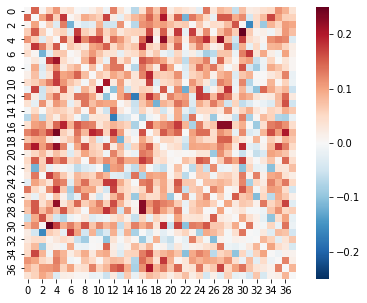

In [43]:
similarity_matrices[8].plot(vmin=-.25, vmax=.25, cmap='RdBu_r')

In [231]:
isc = {node:similarity_matrices[node].isc(metric='mean', n_bootstraps=1, n_jobs=1)['isc'] for node in range(n_nodes)}

# IS-RSA

In [478]:
isrsa_nn, isrsa_annak = {}, {}
for node in range(len(similarity_matrices)):
    isrsa_nn[node] = similarity_matrices[node].similarity(behav_sim_nn, metric='spearman', n_permute=1, n_jobs=1 )['correlation']
    isrsa_annak[node] = similarity_matrices[node].similarity(behav_sim_annak, metric='spearman', n_permute=1, n_jobs=1 )['correlation']

In [479]:
cleanedList_nn = [x for x in isrsa_nn.values() if str(x) != 'nan']

In [480]:
cleanedList_annak = [x for x in isrsa_annak.values() if str(x) != 'nan']

Text(0.2, 40, 't=1.38, p = 0.217')

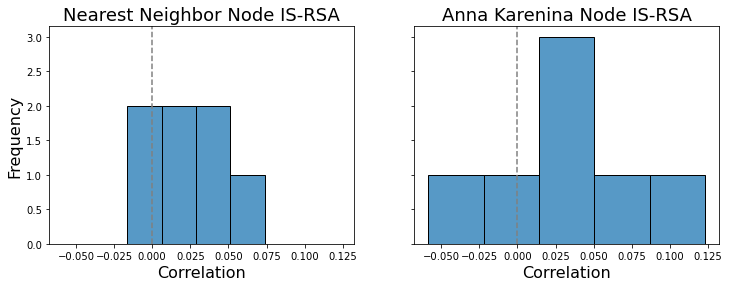

In [481]:
#cleanedList_annak = [x for x in isrsa_annak.values() if str(x) != 'nan']
f, a = plt.subplots(ncols=2, figsize=(12,4), sharex=True, sharey=True)
sns.histplot(list(cleanedList_nn), ax=a[0])
a[0].axvline(0, color='gray', linestyle='--');
a[0].set_ylabel('Frequency', fontsize=16)
a[0].set_xlabel('Correlation', fontsize = 16)
a[0].set_title('Nearest Neighbor Node IS-RSA', fontsize=18)
t, p = ttest_1samp(list(cleanedList_nn), 0)
a[0].annotate(f't={t:.2f}, p = {p:.03f}', xy = (.2, 40),fontsize=16, color='gray')

sns.histplot(list(cleanedList_annak), ax=a[1])
a[1].axvline(0, color='gray', linestyle='--');
a[1].set_ylabel('Frequency', fontsize=16)
a[1].set_xlabel('Correlation', fontsize = 16)
a[1].set_title('Anna Karenina Node IS-RSA', fontsize=18)
t, p = ttest_1samp(list(cleanedList_annak), 0)
a[1].annotate(f't={t:.2f}, p = {p:.03f}', xy = (.2, 40),fontsize=16, color='gray')

In [ ]:
#Permutation tests to derive voxels/ROIs significantly correlated with Behaviral matrices
isrsa_nn_r, isrsa_nn_p = {}, {}
isrsa_annak_r, isrsa_annak_p = {}, {}
for node in range(len(similarity_matrices)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(similarity_matrices)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    stats_nn = similarity_matrices[node].similarity(behav_sim_nn, metric='spearman', n_permute=10000, n_jobs=-1, tail = 1)
    isrsa_nn_r[node] = stats_nn['correlation']
    isrsa_nn_p[node] = stats_nn['p']
    
    stats_annak = similarity_matrices[node].similarity(behav_sim_annak, metric='spearman', n_permute=10000, n_jobs=-1,tail = 1)
    isrsa_annak_r[node] = stats_annak['correlation']
    isrsa_annak_p[node] = stats_annak['p']

In [72]:
#multiple comparison correction 
import statsmodels.stats.multitest as multi

[reject,p_corre,alpha_sak,alpha_bon] = multi.multipletests(pd.Series(liata).values,method= 'fdr_bh')

vox_n = 5
p_corre_reshape = np.reshape(p_corre,(1,vox_n))
isrsa_annak_r_corre = pd.Series(isrsa_annak_r).values
isrsa_annak_r_corre_reshape = np.reshape(isrsa_annak_r_corre,(1,vox_n))

In [51]:
#threholding r values with significant p-values (FDR-corrected)
for index in range(len(p_corre_reshape[0])):
    if p_corre_reshape[0][index] > 0.05:
        isrsa_nn_r_corre_reshape[0][index] = 0
        isrsa_sig_p_corre_reshape[0][index] = -1

In [39]:
#Conctructing nii images after threholding
# Set up logger first
logger = logging.getLogger(__name__)

def load_mask(mask_arg):

    # Load mask from file
    mask = nib.load(mask_arg).get_fdata().astype(bool)

    # Get indices of voxels in mask
    mask_indices = np.where(mask)

    logger.info("finished loading mask from "
                "'{0}'".format(mask_arg))

    return mask, mask_indices


# Function to convert array back to NIfTI image
def to_nifti(iscs, affine, header, mask_indices):

    # Output ISCs image shape
    i, j, k = header.get_data_shape()[:3]
    nifti_shape = (i, j, k, iscs.shape[0])

    # Reshape masked data
    if mask_indices:
        nifti_iscs = np.zeros(nifti_shape)
        nifti_iscs[mask_indices] = iscs.T
    else:
        nifti_iscs = iscs.T.reshape(nifti_shape)

    # Construct output NIfTI image
    nifti_img = nib.Nifti1Image(nifti_iscs, affine)

    return nifti_img

In [41]:
input_img = nib.load('path_to_an_nii_file')
affine, header = input_img.affine, input_img.header
gm_mask, mask_indices = load_mask('path-to-a-grey-matter-mask')

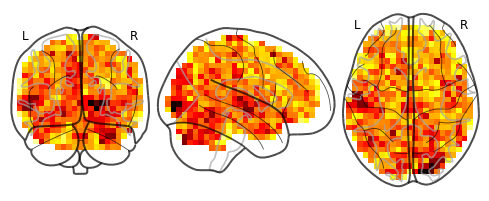

In [46]:
r_values = isrsa_nn_r_corre_reshape/isrsa_annak_r_corre_reshape
output_img = to_nifti(r_values, affine, header, mask_indices)

from nilearn import plotting
plotting.plot_glass_brain(output_img, threshold=0)

In [51]:
output_merged = 'path-to-output-image'
nib.save(output_img, output_merged)